In [21]:
import kagglehub
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

scaler = MinMaxScaler()

# get dataset
path = kagglehub.dataset_download("hassan06/nslkdd")
print("Path to dataset files:", path)

train_name, test_name = 'KDDTrain+.arff', 'KDDTest+.arff'

Path to dataset files: /home/joao/.cache/kagglehub/datasets/hassan06/nslkdd/versions/1


In [2]:
# couldn't get arff loading libaries to work, so I'll do it manually
def parse_arff(p):
    with open(p, 'r') as f:
        lines = f.readlines()

        attribute_strings = [l.replace('\n', '').replace('@attribute ', '') for l in lines if l.startswith('@attribute')]

        attributes = {}
        for s in attribute_strings:
            # we only have attribute type real or categorical in this dataset
            att_name = s[0:s.find(' ')].replace('\'', '')
            if s.endswith('real'):
                attributes[att_name] = 'real'
            else:
                attributes[att_name] = eval(s[s.find(' ')+1:])

        data_ind = -1 # data starts at this index
        for i in range(len(lines)):
            if lines[i].find('@data') != -1:
                data_ind = i+1
        
        data = [] 
        positional_attribs = list(attributes.items()) # python 3.7+ guarantees dict order of insertion
        for d in lines[data_ind:]:
            attribs = d.replace('\n', '').split(',')
            row = []
            for i in range(len(attribs)):
                if positional_attribs[i][1] == 'real' or str(positional_attribs[i][1]) == '{\'0\', \'1\'}':
                    row.append(float(attribs[i]))
                else:
                    row.append(str(attribs[i]))
            data.append(row)

    return attributes, data

In [3]:
attributes, train_data = parse_arff(path+'/'+train_name)
_, test_data = parse_arff(path+'/'+test_name)

train_data_df = pd.DataFrame(train_data, columns=list(attributes.keys()))
test_data_df = pd.DataFrame(test_data, columns=list(attributes.keys()))

# exclude anomalous entries for training set
train_data_df = train_data_df[train_data_df['class'] == 'normal']

# one hot encode categorical data (train and test)
train_data_df['service'] = pd.Categorical(train_data_df['service'], categories=attributes['service'])
train_data_df['flag'] = pd.Categorical(train_data_df['flag'], categories=attributes['flag'])
train_data_df = pd.get_dummies(train_data_df, columns=['protocol_type', 'service', 'flag'])

test_data_df['service'] = pd.Categorical(test_data_df['service'], categories=attributes['service'])
test_data_df['flag'] = pd.Categorical(test_data_df['flag'], categories=attributes['flag'])
test_data_df = pd.get_dummies(test_data_df, columns=['protocol_type', 'service', 'flag'])

In [4]:
# before normalizing, let's see if we don't have any huge outliers since we're doing minmax scaling
# we can exclude our hot encoded ones, and also ignore any of the rate features or booleans
columns = list(train_data_df.columns)
excluded_indexes = [i for i in range(columns.index('class'), len(columns))] # exclude all categorical hot encoded 

combined_np = np.vstack((train_data_df.to_numpy(), test_data_df.to_numpy()))
for i in range(len(columns)):
    if i not in excluded_indexes:
        col = combined_np[:, i]
        std = col.std()
        if std != 0 and columns[i].find('rate') == -1 and columns[i].find('is_') == -1: 
            z_col = col/std
            z_col = z_col[(z_col > 6) | (z_col < -6)] # count entries that are beyond 6 z-score range

            # DEBUG
            #print(f'for column {i} ({columns[i]}) std is {std:.2f}:', len(z_col))
            #print(f'\t z-score of 6 corresponds to {std*6:.2f}')
    
            # filter extremes
            train_data_df = train_data_df[train_data_df[columns[i]] <= std*6]
            test_data_df = test_data_df[test_data_df[columns[i]] <= std*6]
        
# investigate by plotting our samples
#plt.scatter(np.linspace(0, 100000, len(train_data_df['duration'])), train_data_df['duration'], s=1)

# maybe log transform some of the fields that have 0 or large values
train_data_df['duration'] = np.log(train_data_df['duration']+0.001)
train_data_df['src_bytes'] = np.log(train_data_df['src_bytes']+0.001)
train_data_df['dst_bytes'] = np.log(train_data_df['dst_bytes']+0.001)

In [5]:
print(len(train_data_df))
print(len(test_data_df))

65614
20880


In [6]:
# get rid of class column for training and normalize
train_data_df = train_data_df.drop(columns=['class'])
data = scaler.fit_transform(train_data_df)

In [9]:
# We'll use pytorch to implement our model
# source for architecture: https://pmc.ncbi.nlm.nih.gov/articles/PMC8272075/pdf/sensors-21-04294.pdf
# Apparently, it looks like different depth and hidden layer neuron numbers achieve very similar results on this dataset
# We'll go for a symmetric autoencoder with depth of 5 with 64 neurons on the first hidden layer (subsequent layers divide number of neurons by 2)
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, latent_dim),
            # torch.nn.ReLU() MAYBE?
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


class SampleDataset(Dataset): # want this so I can use dataloader
    def __init__(self, data_matrix, labels=None):
        self.data = torch.from_numpy(data_matrix).float()

        if torch.cuda.is_available():
            self.data = self.data.to('cuda')
        
        self.labels = labels
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, ind):
        if self.labels is None:
            return self.data[ind]
        else:
            return (self.data[ind], self.labels[ind])
    

In [10]:
model = Autoencoder(data.shape[1], 3)

if torch.cuda.is_available():
    model = model.to('cuda')

#model.forward(torch.from_numpy(data[0]).float())

loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

dataset = SampleDataset(data)
loader = DataLoader(dataset, shuffle=True, batch_size=64)

In [12]:
MAX_EPOCH = 20

loss_log = []
for e in range(MAX_EPOCH):
    print('AT EPOCH ' + str(e))
    loss_sum = 0
    count = 0
    for s in loader:
        count += 1
        
        output = model.forward(s)
        loss = loss_fun(output, s)
        loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            loss_log.append(loss_sum/count)

AT EPOCH 0
AT EPOCH 1
AT EPOCH 2
AT EPOCH 3
AT EPOCH 4
AT EPOCH 5
AT EPOCH 6
AT EPOCH 7
AT EPOCH 8
AT EPOCH 9
AT EPOCH 10
AT EPOCH 11
AT EPOCH 12
AT EPOCH 13
AT EPOCH 14
AT EPOCH 15
AT EPOCH 16
AT EPOCH 17
AT EPOCH 18
AT EPOCH 19


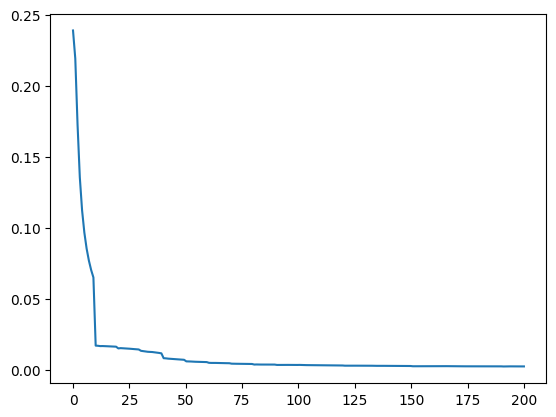

In [13]:
plt.plot(np.linspace(0, len(loss_log), len(loss_log)), loss_log)

In [54]:
# Determine threshold for anomaly based on train set
errors = np.array([])
with torch.no_grad():
    for s in loader:
        reconstruction = model.forward(s)
        e = np.mean(((reconstruction-s)**2).cpu().numpy(), axis=1) # along elements of each row
        errors = np.concatenate((errors, e))

std = errors.std()
print(f'Standard deviation: {std}')

# for now let's say 4 z scores away is anomaly
threshold_error = std*4
print(f': {threshold_error}')

Standard deviation: 0.005464605320023327
: 0.02185842128009331


In [70]:
# Test set inference
data = scaler.fit_transform(test_data_df.drop(columns=['class']))

test_dataset = SampleDataset(data, test_data_df['class'].to_numpy())
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=64)

correct = 0
total = 0
with torch.no_grad():
    for samples in test_loader:
        inputs, labels = samples

        reconstruction = model.forward(inputs)
        
        e = np.mean(((reconstruction-inputs)**2).cpu().numpy(), axis=1)
        anomalies = e > threshold_error

        correct += (anomalies == [True if l == 'anomaly' else False for l in labels]).sum()
        total += 64

print(f'{100*(correct/total):.3f}%')

85.378%
